# Decision tree classifier: diabetes prediction

## 1. Data acquisition

### 1.1. Load

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedShuffleSplit

# Set random seed for notebook
random_seed=42

# Set train-test split fraction
testing_fraction=0.33

# Cross-validation method
cv_method=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_seed)
#cv_method=StratifiedShuffleSplit(n_splits=100, test_size=0.5, random_state=random_seed)

# Class weighting for decision trees
class_weights=None

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 1.2. Train-test split

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing, setting the random seed
# so that we get the same test-train split every time we run the notebook
training_df, testing_df=train_test_split(
    data_df,
    test_size=testing_fraction,
    random_state=random_seed
)

# Reset the indexes
training_df.reset_index(inplace=True, drop=True)
testing_df.reset_index(inplace=True, drop=True)

In [3]:
# Get features and labels
training_labels=training_df['Outcome']
training_features=training_df.drop('Outcome', axis=1)

### 1.3. Inspect the data types

In [4]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               514 non-null    int64  
 1   Glucose                   514 non-null    int64  
 2   BloodPressure             514 non-null    int64  
 3   SkinThickness             514 non-null    int64  
 4   Insulin                   514 non-null    int64  
 5   BMI                       514 non-null    float64
 6   DiabetesPedigreeFunction  514 non-null    float64
 7   Age                       514 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 32.2 KB


In [5]:
training_labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 514 entries, 0 to 513
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
514 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [6]:
list(training_labels[:10])

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]

## 3. Baseline decision tree classifier

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments={'Baseline': scores * 100}

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.4%



Model is 100.0% accurate on the training data
Fitted tree depth: 11

Feature importances:
 Pregnancies: 0.059
 Glucose: 0.362
 BloodPressure: 0.074
 SkinThickness: 0.061
 Insulin: 0.040
 BMI: 0.168
 DiabetesPedigreeFunction: 0.105
 Age: 0.131



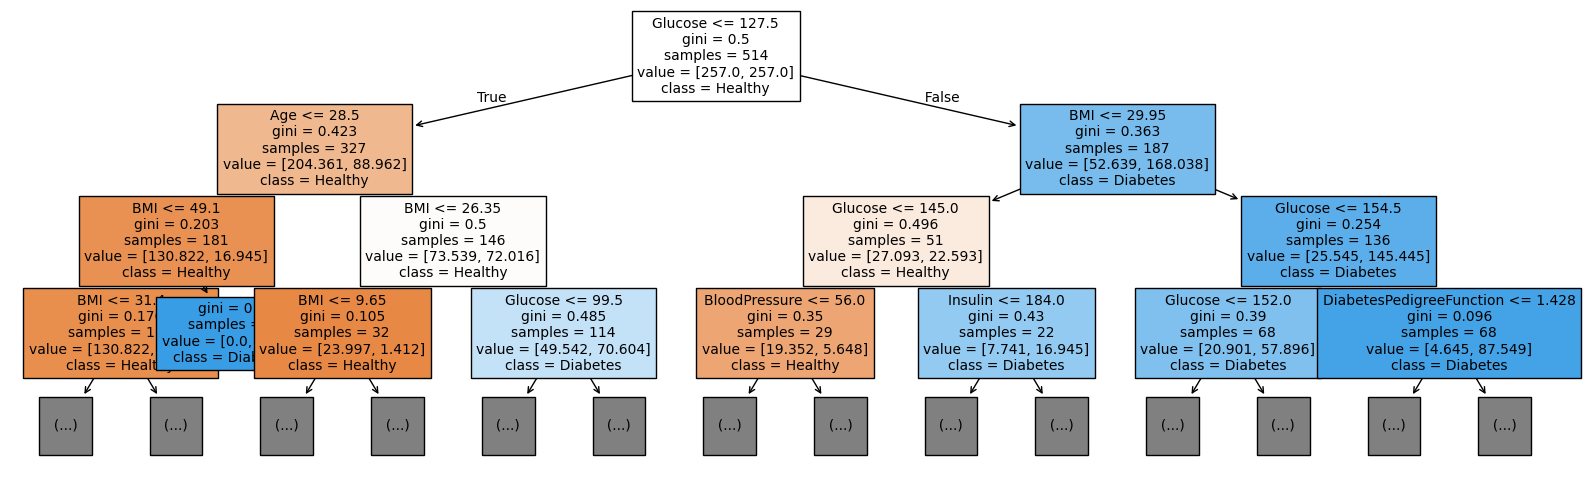

In [8]:
# Let's take a look at the tree
import matplotlib.pyplot as plt
from sklearn import tree

model=DecisionTreeClassifier(random_state=random_seed, class_weight='balanced')
fit_result=model.fit(training_features, training_labels)

# Make predictions from test set features
predicted_labels=model.predict(training_features)

# Score predictions for accuracy
percent_accuracy=accuracy_score(training_labels, predicted_labels) * 100

# Show some details about the model
print(f'\nModel is {percent_accuracy:.1f}% accurate on the training data')
print(f'Fitted tree depth: {fit_result.tree_.max_depth}')
print('\nFeature importances:')

for feature, importance in zip(training_features.columns, fit_result.tree_.compute_feature_importances()):
    print(f' {feature}: {importance:.3f}')

print()

# Plot the first few levels of the tree
fig=plt.figure(figsize=(20,6))

tree.plot_tree(model,
    feature_names=list(training_features.columns),
    class_names=['Healthy', 'Diabetes'],
    filled=True,
    fontsize=10,
    max_depth=3
)

plt.show()

## 2. EDA/feature engineering

### 2.1. Feature distributions

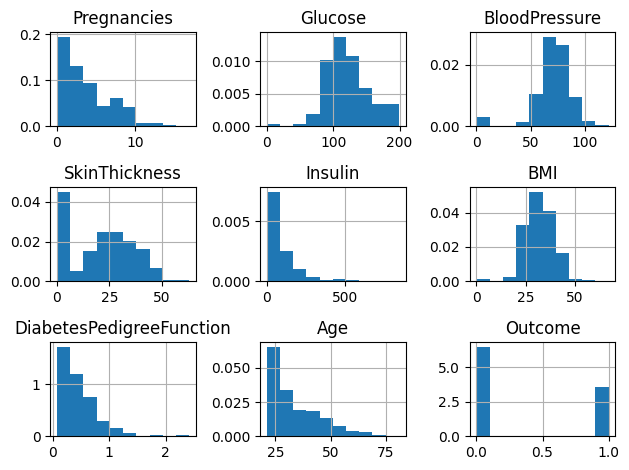

In [9]:
training_df.hist(density=True, layout=(3,3))
plt.tight_layout()
plt.show()

In [10]:
training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,3.782101,121.295720,69.984436,20.525292,79.237354,31.969844,0.473089,33.190661,0.354086
std,3.277187,32.358526,18.008763,15.501504,115.642548,7.649192,0.341989,11.731010,0.478701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,26.925000,0.244250,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,34.000000,32.000000,0.383500,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,125.750000,36.500000,0.614500,41.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


First weird observation... we have at least one record where everything except DPF and age is zero - I'm pretty sure that someone didn't have zero blood pressure or zero skin thickness! That's probably missing data. Just how much is there?

In [11]:
dead_people=len(training_df[training_df['BloodPressure'] == 0])
print(f'Have {dead_people} people with a blood pressure of 0')

Have 18 people with a blood pressure of 0


### 2.2. Missing values

Ok, if we were to remove rows that contain zero in one of 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin' or 'BMI', how much data would we have left?

In [12]:
# Features to look for zeros in
missing_data_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Remove rows that have at least one zeros, using a copy, in case we decide it's a bad idea
filtered_training_df=training_df.copy()
filtered_training_df[missing_data_features]=filtered_training_df[missing_data_features].replace({0:np.nan})
filtered_training_df.dropna(inplace=True)

filtered_training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,3.335878,124.019084,70.847328,28.904580,155.110687,32.856870,0.511737,30.832061,0.332061
std,3.124764,30.748074,12.670885,10.626832,120.283283,7.188289,0.349665,10.129546,0.471854
min,0.000000,56.000000,24.000000,10.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,100.000000,62.500000,21.000000,79.000000,27.500000,0.273000,23.000000,0.000000
50%,2.000000,120.000000,70.000000,28.500000,125.000000,32.800000,0.443500,27.000000,0.000000
75%,5.000000,143.000000,80.000000,36.000000,182.750000,37.175000,0.653000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Wow, ok - so that's almost half of our data! We can't just throw all of those examples away. Let's try a simple imputation for each feature.

#### 2.2.1. Simple imputation

In [13]:
simple_imputed_training_features=training_features.copy()

for target_feature in missing_data_features:

    impute_data=simple_imputed_training_features[simple_imputed_training_features[target_feature] != 0][target_feature]
    target_feature_imputed_value=impute_data.median()
    imputed_data=simple_imputed_training_features[target_feature].replace({0:target_feature_imputed_value})
    simple_imputed_training_features[target_feature]=imputed_data

    print(f'{target_feature} imputed value: {target_feature_imputed_value:.1f}')

simple_imputed_training_features.describe()

Glucose imputed value: 118.0
BloodPressure imputed value: 72.0
SkinThickness imputed value: 29.0
Insulin imputed value: 125.0
BMI imputed value: 32.0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,3.782101,122.214008,72.505837,28.762646,140.278210,32.281128,0.473089,33.190661
std,3.277187,30.522048,12.092761,8.535335,87.135766,6.960701,0.341989,11.731010
min,0.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,24.000000,120.000000,27.125000,0.244250,24.000000
50%,3.000000,118.000000,72.000000,29.000000,125.000000,32.000000,0.383500,29.000000
75%,6.000000,140.000000,80.000000,32.000000,125.750000,36.500000,0.614500,41.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


Try the cross-validation again and see how we did.

In [14]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    simple_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Simple imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.5%


No real improvement. Let's try a little bit more advanced of an imputation strategy from scikit-learn:

#### 2.2.2. Scikit-learn IterativeImputer

In [15]:
from utils import impute 

iterative_imputed_training_features, imp, qt=impute(training_features, missing_data_features)

[IterativeImputer] Completing matrix with shape (514, 8)
[IterativeImputer] Completing matrix with shape (514, 8)


In [16]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    iterative_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.9 +/- 4.3%


Maybe a bit better, but not strikingly so..

### 2.3. Manual feature selection

#### 2.3.1. Feature cross-correlation

Let's take a look at the cross-correlation matrix for the training features and manually remove any that are highly correlated.

Have 8 features for plot:
 0: Pregnancies
 1: Glucose
 2: BloodPressure
 3: SkinThickness
 4: Insulin
 5: BMI
 6: DiabetesPedigreeFunction
 7: Age


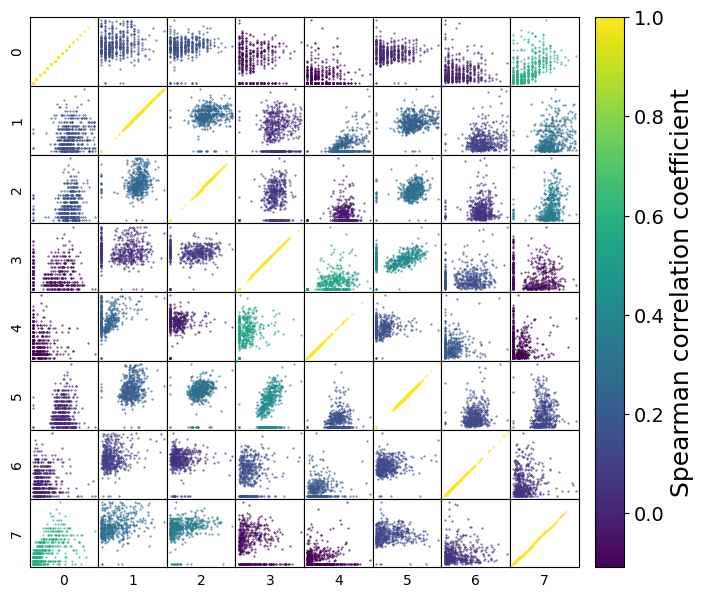

In [17]:
from utils import plot_scatter_matrix

plot_scatter_matrix(training_features).show()

#### 2.3.2. Feature mutual information

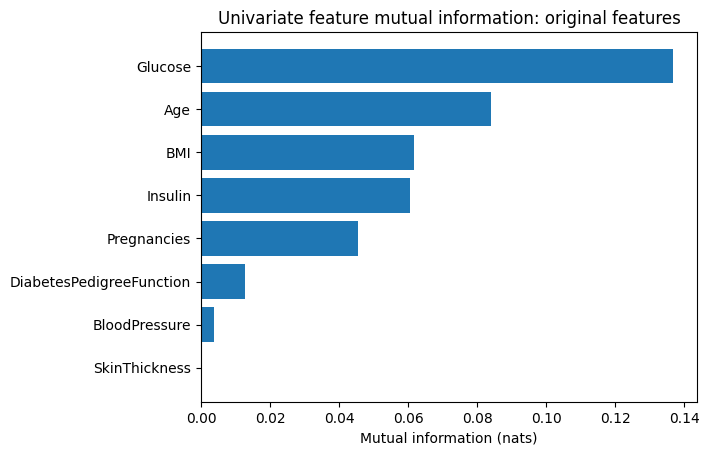

In [18]:
from sklearn.feature_selection import mutual_info_classif

results=mutual_info_classif(training_features, training_labels)

univariate_mi_results={}

for feature, result in zip(training_features.columns, results):
    univariate_mi_results[feature]=result

univariate_mi_results=dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

plt.title('Univariate feature mutual information: original features')

plt.barh(
    np.arange(len(univariate_mi_results.values())),
    univariate_mi_results.values(),
    tick_label=list(univariate_mi_results.keys())
)

plt.xlabel('Mutual information (nats)')

plt.show()

In [19]:
# Base on the plots above, let's try using the following features
manually_selected_feature_names=['Glucose','BMI','Age']
manually_selected_training_features=training_features[manually_selected_feature_names]

In [20]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    manually_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Manual feature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.9 +/- 4.6%


Also, a very small improvement if any.

### 2.4. Automated feature selection

In [21]:
from sklearn.feature_selection import RFECV

min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed)

rfecv=RFECV(
    estimator=model,
    step=1,
    cv=cv_method,
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1
)

rfecv.fit(training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 8


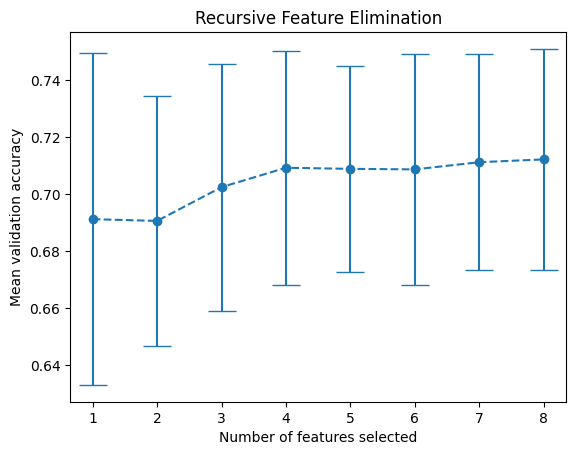

In [22]:
import matplotlib.pyplot as plt

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean validation accuracy')
plt.errorbar(
    x=cv_results['n_features'],
    y=cv_results['mean_test_score'],
    yerr=cv_results['std_test_score'],
    capsize=10,
    marker='o',
    linestyle='dashed'
)
plt.title('Recursive Feature Elimination')
plt.show()

Not a striking difference between feature sets. They are all within a standard deviation or so of each other.

In [23]:
automatically_selected_training_features=training_features.to_numpy()
automatically_selected_training_features=automatically_selected_training_features[:,rfecv.get_support()]

automatically_selected_feature_names=[b for a, b in zip(rfecv.get_support(), training_features.columns) if a]
automatically_selected_training_features=pd.DataFrame(data=automatically_selected_training_features, columns=automatically_selected_feature_names)
automatically_selected_training_features.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,10.0,115.0,98.0,0.0,0.0,24.0,1.022,34.0
1,7.0,142.0,60.0,33.0,190.0,28.8,0.687,61.0
2,4.0,116.0,72.0,12.0,87.0,22.1,0.463,37.0
3,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0
4,3.0,78.0,70.0,0.0,0.0,32.5,0.270,39.0


In [24]:
automatically_selected_training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               514 non-null    float64
 1   Glucose                   514 non-null    float64
 2   BloodPressure             514 non-null    float64
 3   SkinThickness             514 non-null    float64
 4   Insulin                   514 non-null    float64
 5   BMI                       514 non-null    float64
 6   DiabetesPedigreeFunction  514 non-null    float64
 7   Age                       514 non-null    float64
dtypes: float64(8)
memory usage: 32.2 KB


In [25]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    automatically_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Automatic feature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.4%


### 2.5. Results

Let's take a look at how we are doing so far by plotting the cross-validation results we have collected.

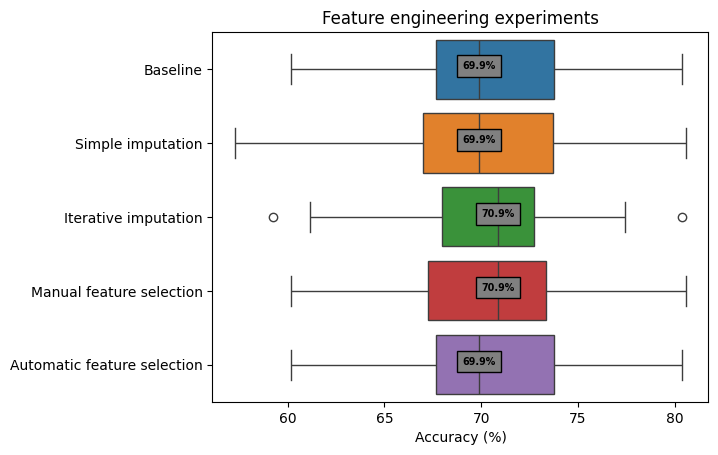

In [26]:
from utils import plot_cross_validation

plot_cross_validation('Feature engineering experiments', experiments).show()

### 2.6. Follow-up experiments

Just for fun, let's try some combinations of the above strategies before we move on. For example, what happens if we do imputation and then feature selection?

#### 2.6.1. Impute, then select features

In [27]:
from sklearn.feature_selection import RFECV

min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed)

rfecv=RFECV(
    estimator=model,
    step=1,
    cv=cv_method,
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1
)

rfecv.fit(iterative_imputed_training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 5


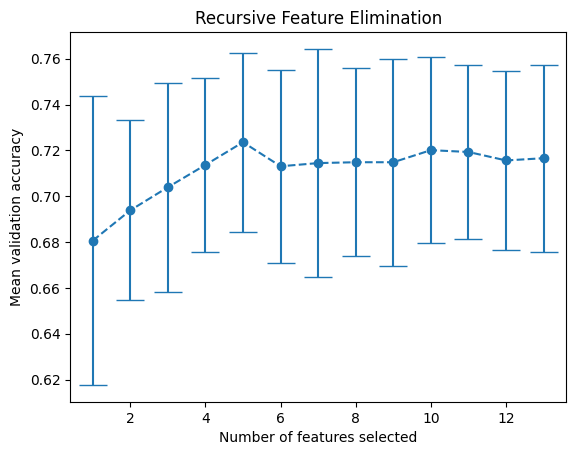

In [28]:
import matplotlib.pyplot as plt

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean validation accuracy')
plt.errorbar(
    x=cv_results['n_features'],
    y=cv_results['mean_test_score'],
    yerr=cv_results['std_test_score'],
    capsize=10,
    marker='o',
    linestyle='dashed'
)
plt.title('Recursive Feature Elimination')
plt.show()

In [29]:
automatically_selected_imputed_training_features=iterative_imputed_training_features.to_numpy()
automatically_selected_imputed_training_features=automatically_selected_imputed_training_features[:,rfecv.get_support()]

automatically_selected_imputed_feature_names=[b for a, b in zip(rfecv.get_support(), iterative_imputed_training_features.columns) if a]
automatically_selected_imputed_training_features=pd.DataFrame(data=automatically_selected_imputed_training_features, columns=automatically_selected_imputed_feature_names)
automatically_selected_imputed_training_features.head()

,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.458333,0.086075,0.108411,1.022,34.0
1,0.762626,0.770833,0.338435,0.687,61.0
2,0.472222,0.291913,0.072897,0.463,37.0
3,0.616162,0.539136,0.404762,0.349,47.0
4,0.083951,0.047885,0.538215,0.270,39.0


In [30]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    automatically_selected_imputed_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation,\nfeature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.7 +/- 3.9%


#### 2.6.2. Select features, then impute

In [31]:
# First we need a new missing data features list that contains only
# missing data features which were selected by the recursive feature elimination
automatically_selected_missing_data_features=[]

for feature in missing_data_features:
    if feature in automatically_selected_training_features.columns:
        automatically_selected_missing_data_features.append(feature)

imputed_automatically_selected_training_features, automatically_selected_features_imp, automatically_selected_features_qt=impute(automatically_selected_training_features, automatically_selected_missing_data_features)

[IterativeImputer] Completing matrix with shape (514, 8)
[IterativeImputer] Completing matrix with shape (514, 8)


In [32]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    imputed_automatically_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Feature selection,\niterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.2 +/- 4.0%


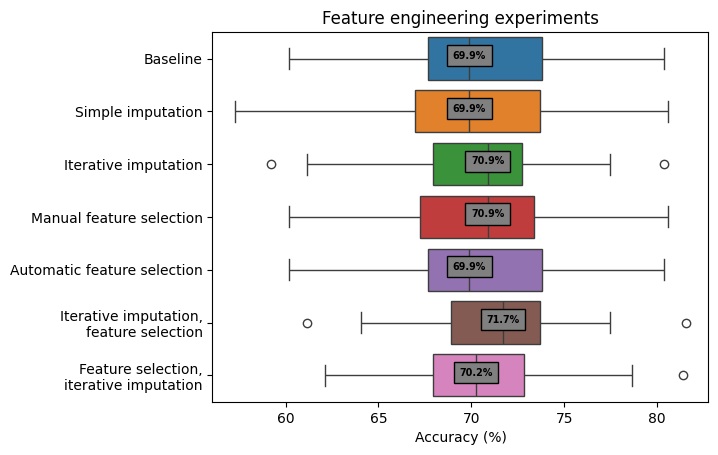

In [33]:
plot_cross_validation('Feature engineering experiments', experiments).show()

## 3. Hyperparameter optimization

Let's try doing this in two stages - first we will try out *criterion*, *splitter* and *class_weight*. These are choices between a few alternative options. Once we have the best combination for this dataset we will do a second round for hyperparameters like *tree_dept* which are int or float.

In [34]:
# Pick the feature set we want to use for hyperparameter tuning
hyperparameter_tuning_features=automatically_selected_imputed_training_features

# Start new results holder for hyperparameter optimization results
hyperparameter_experiments={
    'Baseline': experiments['Baseline'],
    'Iterative imputation,\nfeature selection': experiments['Iterative imputation,\nfeature selection']
}

### 3.1: *Criterion*, *splitter* & *class_weight*

In [35]:
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV

model=DecisionTreeClassifier(random_state=random_seed)

distributions={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}

grid=GridSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    return_train_score=True
)

results=grid.fit(hyperparameter_tuning_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'splitter': 'best'}


**[Scikit-learn defaults](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)**

1. *criterion='gini'*
2. *splitter='best'*
3. *class_weight=None*

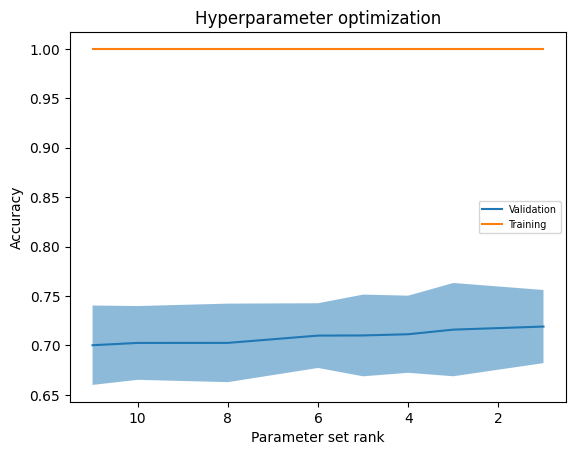

In [36]:
from utils import plot_hyperparameter_tuning

plot_hyperparameter_tuning(results).show()

In [37]:
# Instantiate a model using the winning parameters
model=DecisionTreeClassifier(
    class_weight=results.best_params_['class_weight'],
    criterion=results.best_params_['criterion'],
    splitter=results.best_params_['splitter'],
    random_state=random_seed
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    hyperparameter_tuning_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 1']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.8 +/- 3.7%


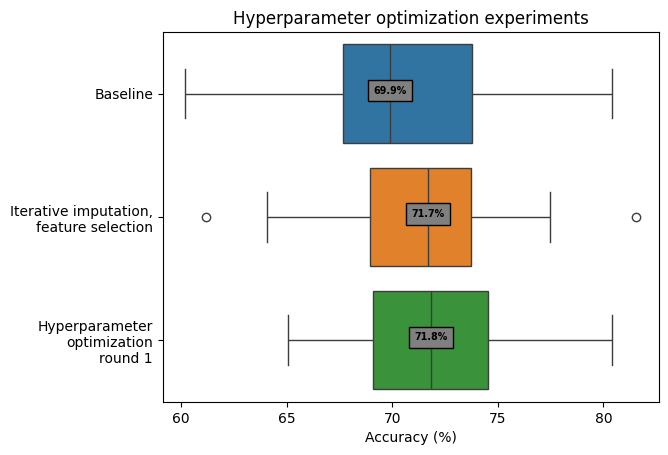

In [38]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

### 3.2: Other hyperparameters

In [39]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

model=DecisionTreeClassifier(random_state=random_seed)

distributions={
    'max_depth': list(range(1, 50)),
    'min_samples_split': list(range(5, 50)),
    'min_samples_leaf': list(range(5, 50)),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_features': uniform(loc=0, scale=1),
    'min_impurity_decrease': uniform(loc=0, scale=1)
}

grid=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv_method,
    n_iter=500,
    random_state=random_seed,
    return_train_score=True
)

results=grid.fit(hyperparameter_tuning_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'max_depth': 22, 'max_features': np.float64(0.5908332605690108), 'min_impurity_decrease': np.float64(0.03050024993904943), 'min_samples_leaf': 46, 'min_samples_split': 10, 'min_weight_fraction_leaf': np.float64(0.1516327573366114)}


/mnt/arkk/4geeks_repos/gperdrizet-decision-tree-project/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


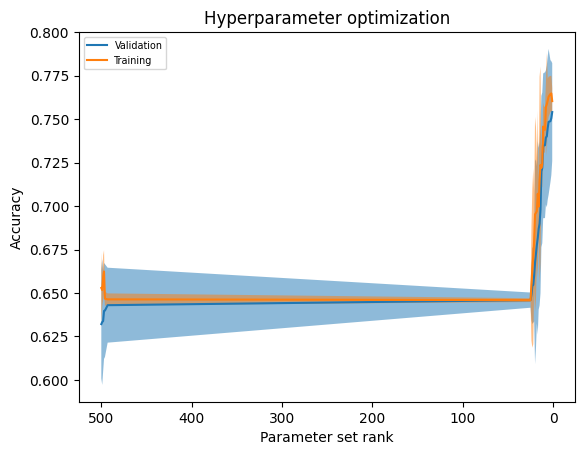

In [40]:
plot_hyperparameter_tuning(results).show()

In [41]:
# Instantiate a model using the winning parameters
model=DecisionTreeClassifier(
    max_depth=results.best_params_['max_depth'],
    max_features=results.best_params_['max_features'],
    min_impurity_decrease=results.best_params_['min_impurity_decrease'],
    min_samples_leaf=results.best_params_['min_samples_leaf'],
    min_samples_split=results.best_params_['min_samples_split'],
    min_weight_fraction_leaf=results.best_params_['min_weight_fraction_leaf'],
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    hyperparameter_tuning_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['Hyperparameter\noptimization\nround 2']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 73.8 +/- 6.5%


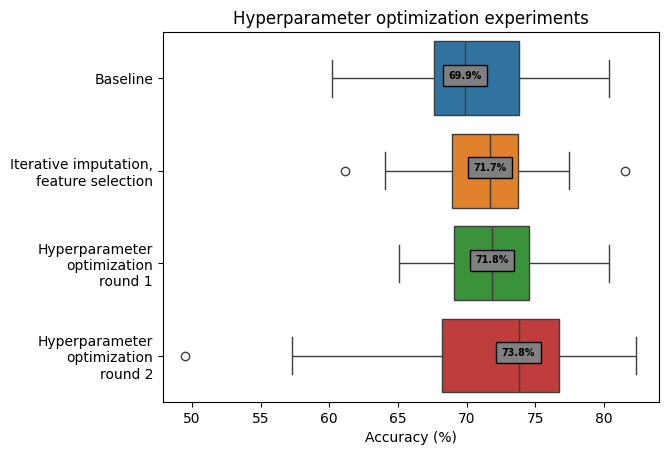

In [42]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

In [43]:
# Finally, fit the model on all of the training data at once
fit_result=model.fit(hyperparameter_tuning_features, training_labels)

## 4. Evaluation

Now it's finally time to see how well the model does on the test data. We should only do this **ONCE**, and we should only do it **AFTER** we have made our final decision about how to prepare the data. If we look at the test data performance and then go back and change our feature engineering to improve it - the result no-longer represents an estimate of the model's performance on 'unseen' test data and therefore is not a true evaluation.

In [44]:
# Get features and labels
testing_labels=testing_df['Outcome']
testing_features=testing_df.drop('Outcome', axis=1)

In [45]:
# Use the quantile transformer and imputer that we fit on the training data to transform the testing data

# Save the feature names for later - the imputer will return a numpy array
# and we might like to get out Pandas dataframe back
feature_names=list(testing_features.columns)

# Make a copy of the testing features
imputed_testing_features=testing_features.copy()
imputed_testing_features[missing_data_features]=imputed_testing_features[missing_data_features].replace({0:np.nan})

# Quantile transform our target features - this is for the imputer, not the decision tree
imputed_testing_features[missing_data_features]=qt.transform(imputed_testing_features[missing_data_features])

# Run the imputation
imputed_testing_features=imp.transform(imputed_testing_features)

# Convert back to pandas
indicator_features=[]
for feature in missing_data_features:
    indicator_features.append(f'{feature}_indicator')

feature_names.extend(indicator_features)
imputed_testing_features=pd.DataFrame(data=imputed_testing_features, columns=feature_names)

[IterativeImputer] Completing matrix with shape (254, 8)


In [46]:
# Get only the selected features from the testing data, using the list
# determined during the feature selection on the training data
selected_imputed_testing_features=imputed_testing_features[automatically_selected_imputed_feature_names]

In [47]:
# Make predictions from test set features
predicted_labels=model.predict(selected_imputed_testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')

Model is 71.7% accurate on the test data


This is a pretty good result - not because it is a super high accuracy score - but instead because we were very close to being right about how accurate the model would be on the test data! Also, we did manage to improve the baseline result by a few percentage points.